 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Feature-importance-from-from-linear-model" data-toc-modified-id="Feature-importance-from-from-linear-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature importance from from linear model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model-and-get-reference-score" data-toc-modified-id="Train-the-model-and-get-reference-score-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train the model and get reference score</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-random-permutation-scores-and-compute-feature-importance" data-toc-modified-id="Get-random-permutation-scores-and-compute-feature-importance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Get random permutation scores and compute feature importance</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Trim-features" data-toc-modified-id="Trim-features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Trim features</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#With-embeddings" data-toc-modified-id="With-embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-feature-importance" data-toc-modified-id="Get-feature-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Neural-net-with-hidden-layer-and-embeddings" data-toc-modified-id="Neural-net-with-hidden-layer-and-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Neural net with hidden layer and embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Evaluate-feature-importance" data-toc-modified-id="Evaluate-feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluate feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Throw-away-&quot;useless&quot;-features" data-toc-modified-id="Throw-away-&quot;useless&quot;-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Throw away "useless" features</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-data" data-toc-modified-id="Get-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Build-a-neural-net-with-only-one-output" data-toc-modified-id="Build-a-neural-net-with-only-one-output-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build a neural net with only one output</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#BOOOOOST" data-toc-modified-id="BOOOOOST-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>BOOOOOST</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#CRPS-objective-function-for-XGBoost" data-toc-modified-id="CRPS-objective-function-for-XGBoost-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>CRPS objective function for XGBoost</a></span></li></ul></div>

# Feature importance

The skill of our models certainly increases with auxiliary variables. Of course we would like to know which of the 38 variables we added actually helped the predictions.

Random permutation importance gives us some insight. For this we randomly permute one feature at a time from the test set and evaluate the decrease in skill.

**TODO**
- Does pruning give more stable validation results? If yes, restructure paper? That would also necessitate rerunning all experiments. 
    - How do I find out. Run simple fc and "best" experiment several times and get variation.
    - But before I need to see if hyper-parameters have to be retuned.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
from nn_src.imports import *
from copy import deepcopy

Using TensorFlow backend.


Anaconda environment: py36_keras
Darwin 17.4.0


In [2]:
DATA_DIR = '/Users/stephanrasp/data/'

In [3]:
# Open the dataset with training = 2015 and test = 2016
with open(DATA_DIR + 'pickled/aux_15_16.pkl', 'rb') as f:
    aux_train_set, aux_test_set = pickle.load(f)

## Feature importance from from linear model

### Train the model and get reference score

In [4]:
n_features = aux_train_set.features.shape[1]; n_features

40

In [5]:
aux_fc_model = build_fc_model(
    n_features=n_features,
    n_outputs=2,
    compile=True,
    lr=0.01
)

In [6]:
aux_fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [7]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [8]:
reset_weights(aux_fc_model)

In [11]:
def avg_score(m, n, x_trn, y_trn, x_test, y_test, **kwargs):
    trn_scores, test_scores = [], []
    for i in tqdm(range(n)):
        reset_weights(m)
        m.fit(x_trn, y_trn, **kwargs)
        trn_scores.append(m.evaluate(x_trn, y_trn, 4096, verbose=0))
        test_scores.append(m.evaluate(x_test, y_test, 4096, verbose=0))
    return trn_scores, test_scores

In [19]:
trn_scores, test_scores = avg_score(
    aux_fc_model, 5,
    aux_train_set.features, aux_train_set.targets,
    aux_test_set.features, aux_test_set.targets,
    epochs=50, batch_size=1024, verbose=0,
)

Widget Javascript not detected.  It may not be installed or enabled properly.


182218/182218 [==============================] - 0s 1us/step



In [20]:
np.mean(trn_scores), np.std(trn_scores)

(0.95444036184238856, 0.0018284824173285352)

In [21]:
np.mean(test_scores), np.std(test_scores)

(0.91991713276001952, 0.0038565126885794746)

In [23]:
# Get the reference score from the last model we trained
# For feature importance small differences are not that crucial
ref_score = aux_fc_model.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0); ref_score

0.92050457876984615

### Get random permutation scores and compute feature importance

In [24]:
def eval_shuf(m, idx, emb=False):
    x_shuf = aux_test_set.features.copy()
    x_shuf[:, idx] = np.random.permutation(x_shuf[:, idx])
    x = [x_shuf, aux_test_set.cont_ids] if emb else x_shuf
    return m.evaluate(x, aux_test_set.targets, 4096, 0)

In [25]:
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(aux_test_set.feature_names))]
    return np.array(scores) - ref_score

In [26]:
fimp = perm_imp(aux_fc_model)

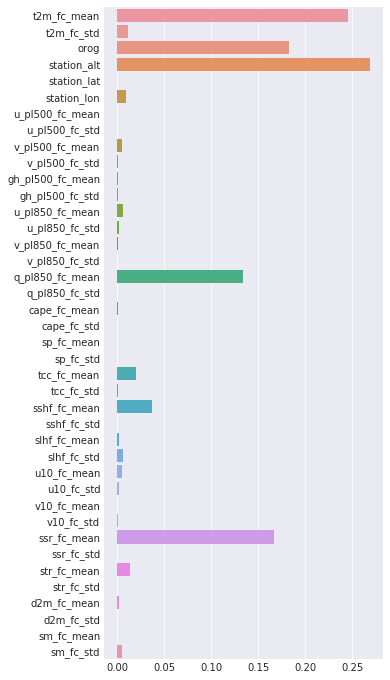

In [27]:
fimp_tmp = fimp.copy(); fimp_tmp[0] /= 20
with plt.style.context(('seaborn-darkgrid')):
    fig, ax = plt.subplots(figsize=(5, 12))
    sns.barplot(x=fimp_tmp, y=aux_test_set.feature_names, ax=ax)
    #plt.xticks(rotation=90);

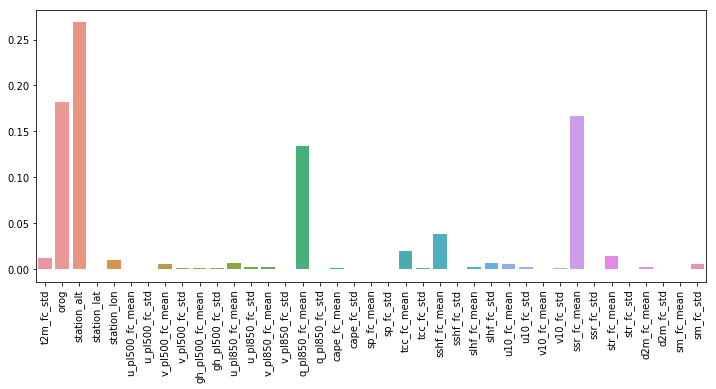

In [28]:
# Do not plot first bar
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp[1:], x=aux_test_set.feature_names[1:], ax=ax)
plt.xticks(rotation=90);

### Trim features

Throw away features that do now contribute much. Let's say with an importance of less than 0.005

In [29]:
thresh = 0.005

In [30]:
def trim_features(cond):
    return aux_train_set.features[:, cond], aux_test_set.features[:, cond]

In [31]:
x_trn_trim, x_test_trim = trim_features(fimp > thresh)
x_trn_trim.shape

(180849, 14)

This leaves 14 out of the 40 features.

In [32]:
aux_fc_model_trim = build_fc_model(
    n_features=14,
    n_outputs=2,
    compile=True,
    lr=0.01
)

In [33]:
aux_fc_model_trim.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [34]:
trn_scores, test_scores = avg_score(
    aux_fc_model_trim, 5,
    x_trn_trim, aux_train_set.targets,
    x_test_trim, aux_test_set.targets,
    epochs=50, batch_size=1024, verbose=0,
)

Widget Javascript not detected.  It may not be installed or enabled properly.


182218/182218 [==============================] - 0s 1us/step



In [35]:
np.mean(trn_scores), np.std(trn_scores)

(0.96429037735451895, 0.00090936288930071297)

In [36]:
np.mean(test_scores), np.std(test_scores)

(0.91769490035665791, 0.0017434400075674911)

## With embeddings

### Train the model

In [38]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [28]:
aux_emb_model = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.01)
aux_emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 2)          1074        input_4[0][0]                    
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2)             0           embedding_1[0][0]                
___________________________________________________________________________________________

In [29]:
aux_emb_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=50, batch_size=1024, verbose=0);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 3.2274     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 2.0904     
Epoch 3/50
180849/180849 [==============================] - 0s - loss: 1.7208     
Epoch 4/50
180849/180849 [==============================] - 0s - loss: 1.5229     
Epoch 5/50
180849/180849 [==============================] - 0s - loss: 1.3816     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 1.2773     
Epoch 7/50
180849/180849 [==============================] - 0s - loss: 1.1991     
Epoch 8/50
180849/180849 [==============================] - 0s - loss: 1.1383     
Epoch 9/50
180849/180849 [==============================] - 0s - loss: 1.0941     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 1.0594     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 1.0324     
Epoch 12/50
180849/180849 [==============================] - 0s - loss: 1.0127     
E

In [32]:
aux_emb_model.evaluate(
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 4096, 0)

0.90725831819159775

In [30]:
emb_ref_score = aux_emb_model.evaluate(
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
emb_ref_score

0.88260775372673994

### Get feature importance

In [49]:
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(aux_test_set.feature_names))]
    ids_shuf = np.random.permutation(aux_test_set.cont_ids)
    scores += [m.evaluate([aux_test_set.features, ids_shuf], aux_test_set.targets, 4096, 0)]
    return np.array(scores) - ref

In [74]:
fimp_emb = perm_imp_emb(aux_emb_model, emb_ref_score)

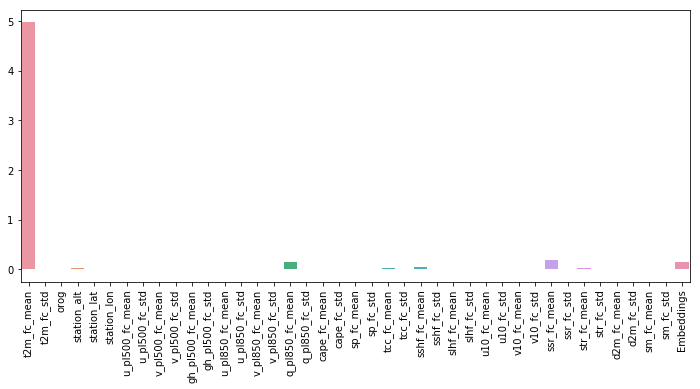

In [75]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb, x=aux_test_set.feature_names + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

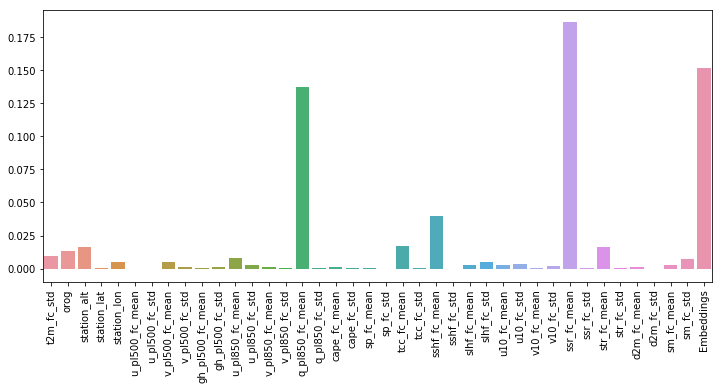

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb[1:], x=aux_test_set.feature_names[1:] + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

## Neural net with hidden layer and embeddings

This is our best configuration for one year of data.

### Train the model

In [39]:
emb_nnet = build_emb_model(n_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)
emb_nnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         1074        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

In [43]:
trn_scores, test_scores = avg_score(
    emb_nnet, 2,
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets,
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

Widget Javascript not detected.  It may not be installed or enabled properly.


182218/182218 [==============================] - 0s 2us/step



In [44]:
np.mean(trn_scores), np.std(trn_scores)

(0.81108041066118952, 0.016306920236707767)

In [45]:
np.mean(test_scores), np.std(test_scores)

(0.85996713242435152, 0.0067335154089772642)

In [46]:
test_scores

[0.86670064783332879, 0.85323361701537426]

In [47]:
emb_nnet_ref = emb_nnet.evaluate(
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
emb_nnet_ref

0.85323361701537426

### Evaluate feature importance

In [50]:
fimp_emb_nnet = perm_imp_emb(emb_nnet, emb_nnet_ref)

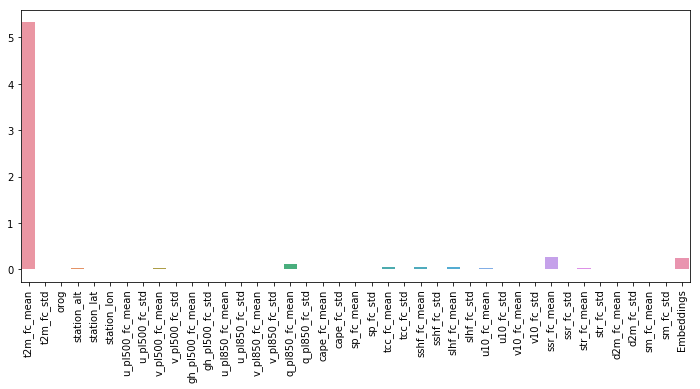

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb_nnet, x=aux_test_set.feature_names + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

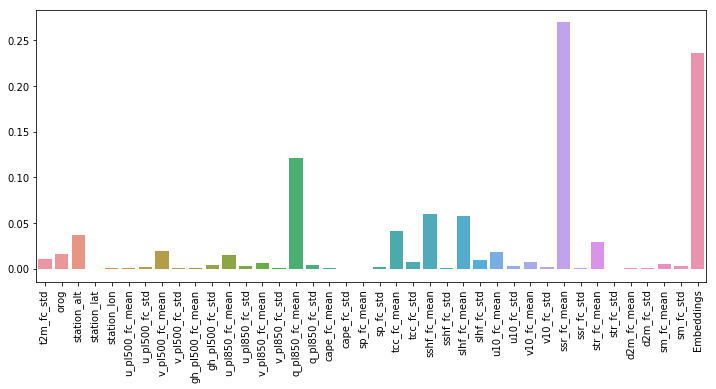

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb_nnet[1:], x=aux_test_set.feature_names[1:] + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

## Throw away "useless" features

In [53]:
# We don't want to throw away the temperature std
fimp_emb_nnet[1]

0.01101788105456103

In [54]:
pos_thresh = 0.005

In [55]:
x_trn_trim, x_test_trim = trim_features(fimp_emb_nnet[:-1] > thresh)
x_trn_trim.shape

(180849, 17)

In [56]:
nnet_trim = build_emb_model(x_trn_trim.shape[1], 2, [50], emb_size, max_id, compile=True, lr=0.01)
nnet_trim.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 2)         1074        input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2)            0           embedding_2[0][0]                
__________________________________________________________________________________________________
concatenat

In [57]:
trn_scores, test_scores = avg_score(
    nnet_trim, 2,
    [x_trn_trim, aux_train_set.cont_ids], aux_train_set.targets,
    [x_test_trim, aux_test_set.cont_ids], aux_test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

Widget Javascript not detected.  It may not be installed or enabled properly.


182218/182218 [==============================] - 0s 1us/step



In [58]:
np.mean(trn_scores), np.std(trn_scores)

(0.84791482727970147, 0.01643610960650882)

In [59]:
np.mean(test_scores), np.std(test_scores)

(0.85371855808444796, 0.0058689788571867907)